# Collecting Data from Earth-Engine-API for Python

This notebook collects data on climate, vegetation, and geophysical variables in the State of California from 2015-2024 at ~10 km resolution.

In [1]:
import ee
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import folium
import contextily as ctx
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geemap

In [6]:
# Trigger the authentication flow.
ee.Authenticate()

True

In [7]:
# Initialize the library.
ee.Initialize(project='ee-ai-firefighter')

In [11]:
# Function to extract data for each image
def extract_for_image(image):
    # Get the date of the image
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
        
    # Sample the image at all points
    reduced = image.reduceRegions(
        collection=points,
        reducer=ee.Reducer.mean(),
        scale=10000
    )
    
    # Add date and coordinates to each feature
    def add_date_coords(feature):
        coords = feature.geometry().coordinates()
        return feature.set({
            'date': date,
            'longitude': coords.get(0),
            'latitude': coords.get(1)
        })
        
    return reduced.map(add_date_coords)

### 1. Define California geometry

In [10]:
california = ee.FeatureCollection('FAO/GAUL/2015/level1') \
    .filter(ee.Filter.eq('ADM1_NAME', 'California')) \
    .first() \
    .geometry() \
    .simplify(maxError=5000)  # Pre-simplified ~5km for efficiency

In [13]:
# Create grid to match ERA5 resolution
grid = california.coveringGrid('epsg:4623', 11132)

In [6]:
# Generate grid points, filter points to only those within California
points = grid.map(lambda feature: feature.centroid(maxError=1)).filterBounds(california)

### 2. Extract ERA5-Land Daily Data at Pixel Resolution

In [177]:
# Set time frame
start_date = '2015-01-01'
end_date = '2025-01-01'

In [178]:
# Get the ERA5-Land dataset
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").filterBounds(california)
    
# Filter by date range
era5_filtered = era5.filterDate(start_date, end_date)
    
# Select key climate variables
# ERA5-Land variable names and descriptions:
climate_vars = [
        'temperature_2m',                      # 2m temperature (K)
        'temperature_2m_max',                  # 2m maximum temperature (K)
        'total_precipitation_sum',             # Total precipitation (m)
        'dewpoint_temperature_2m',             # 2m dewpoint temperature (K)
        'u_component_of_wind_10m',             # 10m u-component of wind (m/s)
        'v_component_of_wind_10m',             # 10m v-component of wind (m/s)
        'volumetric_soil_water_layer_1',       # Volume of water in soil layer 1 (0 - 7 cm)
        'surface_net_solar_radiation_sum',     # Net solar radiation (J/m²)
        'surface_net_thermal_radiation_sum',   # Net thermal radiation (J/m²)
        'surface_sensible_heat_flux_sum',      # Transfer of heat between the Earth's surface and the atmosphere (J/m²)
        'potential_evaporation_sum',           # Potential evaporation (m)
        'total_evaporation_sum',               # Evaporation (m)
        'leaf_area_index_high_vegetation',     # Total green leaf area per unit for high vegetation type
        'leaf_area_index_low_vegetation'       # Total green leaf area per unit for low vegetation type
]
    
# Select only the variables we want
era5_selected = era5_filtered.select(climate_vars)    

In [179]:
# Map over all images and flatten the result
all_data = era5_selected.map(extract_for_image).flatten()

In [180]:
# Create property list for export
export_properties = ['date', 'longitude', 'latitude'] + climate_vars

In [182]:
# Export to Google Drive as CSV
task = ee.batch.Export.table.toDrive(
        collection=all_data,
        description='ERA5_California_Climate_Data',
        folder='GEE_Exports',
        fileNamePrefix='era5_california_climate_data',
        fileFormat='CSV',
        selectors=export_properties
    )
    
# Start the export task
task.start()
    
print(f"\nExport task started")
print(f"Task ID: {task.id}")
    
# Print some statistics
point_count = points.size()
image_count = era5_selected.size()
    
print(f"\nProcessing summary:")
print(f"- Sample points: {point_count.getInfo()}")
print(f"- Time period: {start_date} to {end_date}")
print(f"- Number of daily images: {image_count.getInfo()}")
print(f"- Climate variables: {len(climate_vars)}")
print(f"- Estimated total records: {point_count.getInfo() * image_count.getInfo()}")


Export task started
Task ID: MNI7A4VLHKXPVKUU37ANONMS

Processing summary:
- Sample points: 4170
- Time period: 2015-01-01 to 2025-01-01
- Number of daily images: 3653
- Climate variables: 14
- Estimated total records: 15233010


### 4. Extract NDVI from Modis Dataset

In [12]:
# Set time frame and scale
start_date = '2015-01-01'
end_date = '2022-01-01'
scale = 10000

In [13]:
# Select key vegetation variables
veg_vars = [
        'NDVI',     # Normalized Difference in Vegetation Index
        'EVI'       # Enhanced Vegetation Index
]

In [14]:
# Import filtered MODIS veg. indices
ndvi = ee.ImageCollection("MODIS/061/MOD13Q1") \
            .filterBounds(california) \
            .filterDate(start_date, end_date) \
            .select(veg_vars)

In [15]:
# Map over all images and flatten the result
all_data_n = ndvi.map(extract_for_image).flatten()

In [16]:
# Create property list for export
export_properties = ['date', 'longitude', 'latitude'] + veg_vars

In [17]:
# Export to Google Drive as CSV
task = ee.batch.Export.table.toDrive(
        collection=all_data_n,
        description='MODIS_California_NDVI_Data',
        folder='GEE_Exports',
        fileNamePrefix='modis_ndvi_mean_reduce',
        fileFormat='CSV',
        selectors=export_properties
    )
    
# Start the export task
task.start()
    
print(f"\nExport task started")
print(f"Task ID: {task.id}")
    
# Print some statistics
point_count = points.size()
image_count = ndvi.size()
    
print(f"\nProcessing summary:")
print(f"- Sample points: {point_count.getInfo()}")
print(f"- Time period: {start_date} to {end_date}")
print(f"- Number of 16-day images: {image_count.getInfo()}")
print(f"- Vegetation variables: {len(veg_vars)}")
print(f"- Estimated total records: {point_count.getInfo() * image_count.getInfo()}")


Export task started
Task ID: HQRARMGG2MTETP5XBCFADMAR

Processing summary:
- Sample points: 3363
- Time period: 2015-01-01 to 2022-01-01
- Number of 16-day images: 161
- Vegetation variables: 2
- Estimated total records: 541443


### 5. Extract Digital Elevation Model from NASADEM

In [28]:
dem = ee.Image('NASA/NASADEM_HGT/001') \
        .clip(california) \
        .select('elevation')
slope = ee.Terrain.slope(dem)
aspect = ee.Terrain.aspect(dem)
dem_all = dem.addBands([slope, aspect])

In [32]:
# Calculate point features and convert to GeoDataFrame
point_dem = dem_all.reduceRegions(collection=points, reducer=ee.Reducer.mean(), scale=10000).getInfo()
point_dem = gpd.GeoDataFrame.from_features(point_dem, crs='epsg:4326')

In [34]:
# Optional
point_dem['longitude'] = point_dem.geometry.x
point_dem['latitude'] = point_dem.geometry.y
point_dem.reset_index(drop=True)
point_dem.drop(columns=['geometry'], inplace=True)

In [35]:
point_dem.to_csv(r"/media/scruffy/Elements/python_data/Final/Original Data/dem.csv")

#### Check data quality with visualizations

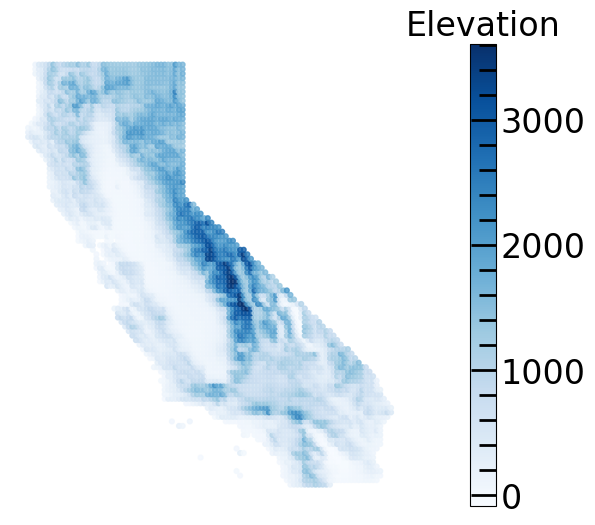

In [172]:
fig, ax= plt.subplots(figsize=(24, 6))

# Define the legend axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the U.S. map with hexagons, where the colour represents the mean air temperature
point_dem.plot(column='elevation', ax=ax, cmap='Blues', alpha=.8, markersize= 12, legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Elevation', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

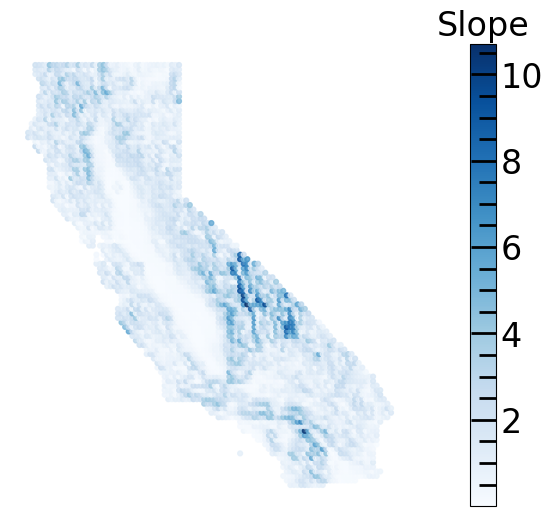

In [176]:
fig, ax= plt.subplots(figsize=(24, 6))

# Define the legend axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the U.S. map with hexagons, where the colour represents the mean air temperature
point_dem.plot(column='slope', ax=ax, cmap='Blues', alpha=.8, markersize= 12, legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Slope', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

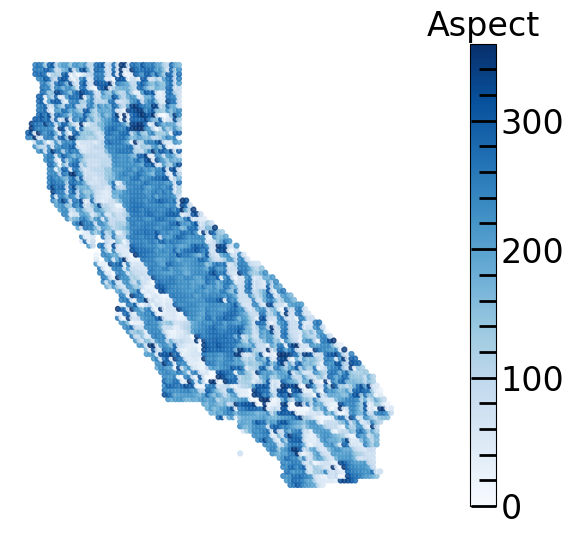

In [175]:
fig, ax= plt.subplots(figsize=(24, 6))

# Define the legend axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the U.S. map with hexagons, where the colour represents the mean air temperature
point_dem.plot(column='aspect', ax=ax, cmap='Blues', alpha=.8, markersize= 12, legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Aspect', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()

### 6. Investigate Sample Points

In [113]:
sample_points_gdf = gpd.GeoDataFrame.from_features(points.getInfo(), crs="EPSG:4326")

Starting sample points visualization...
This may take a few minutes to process...
Adding basemap...


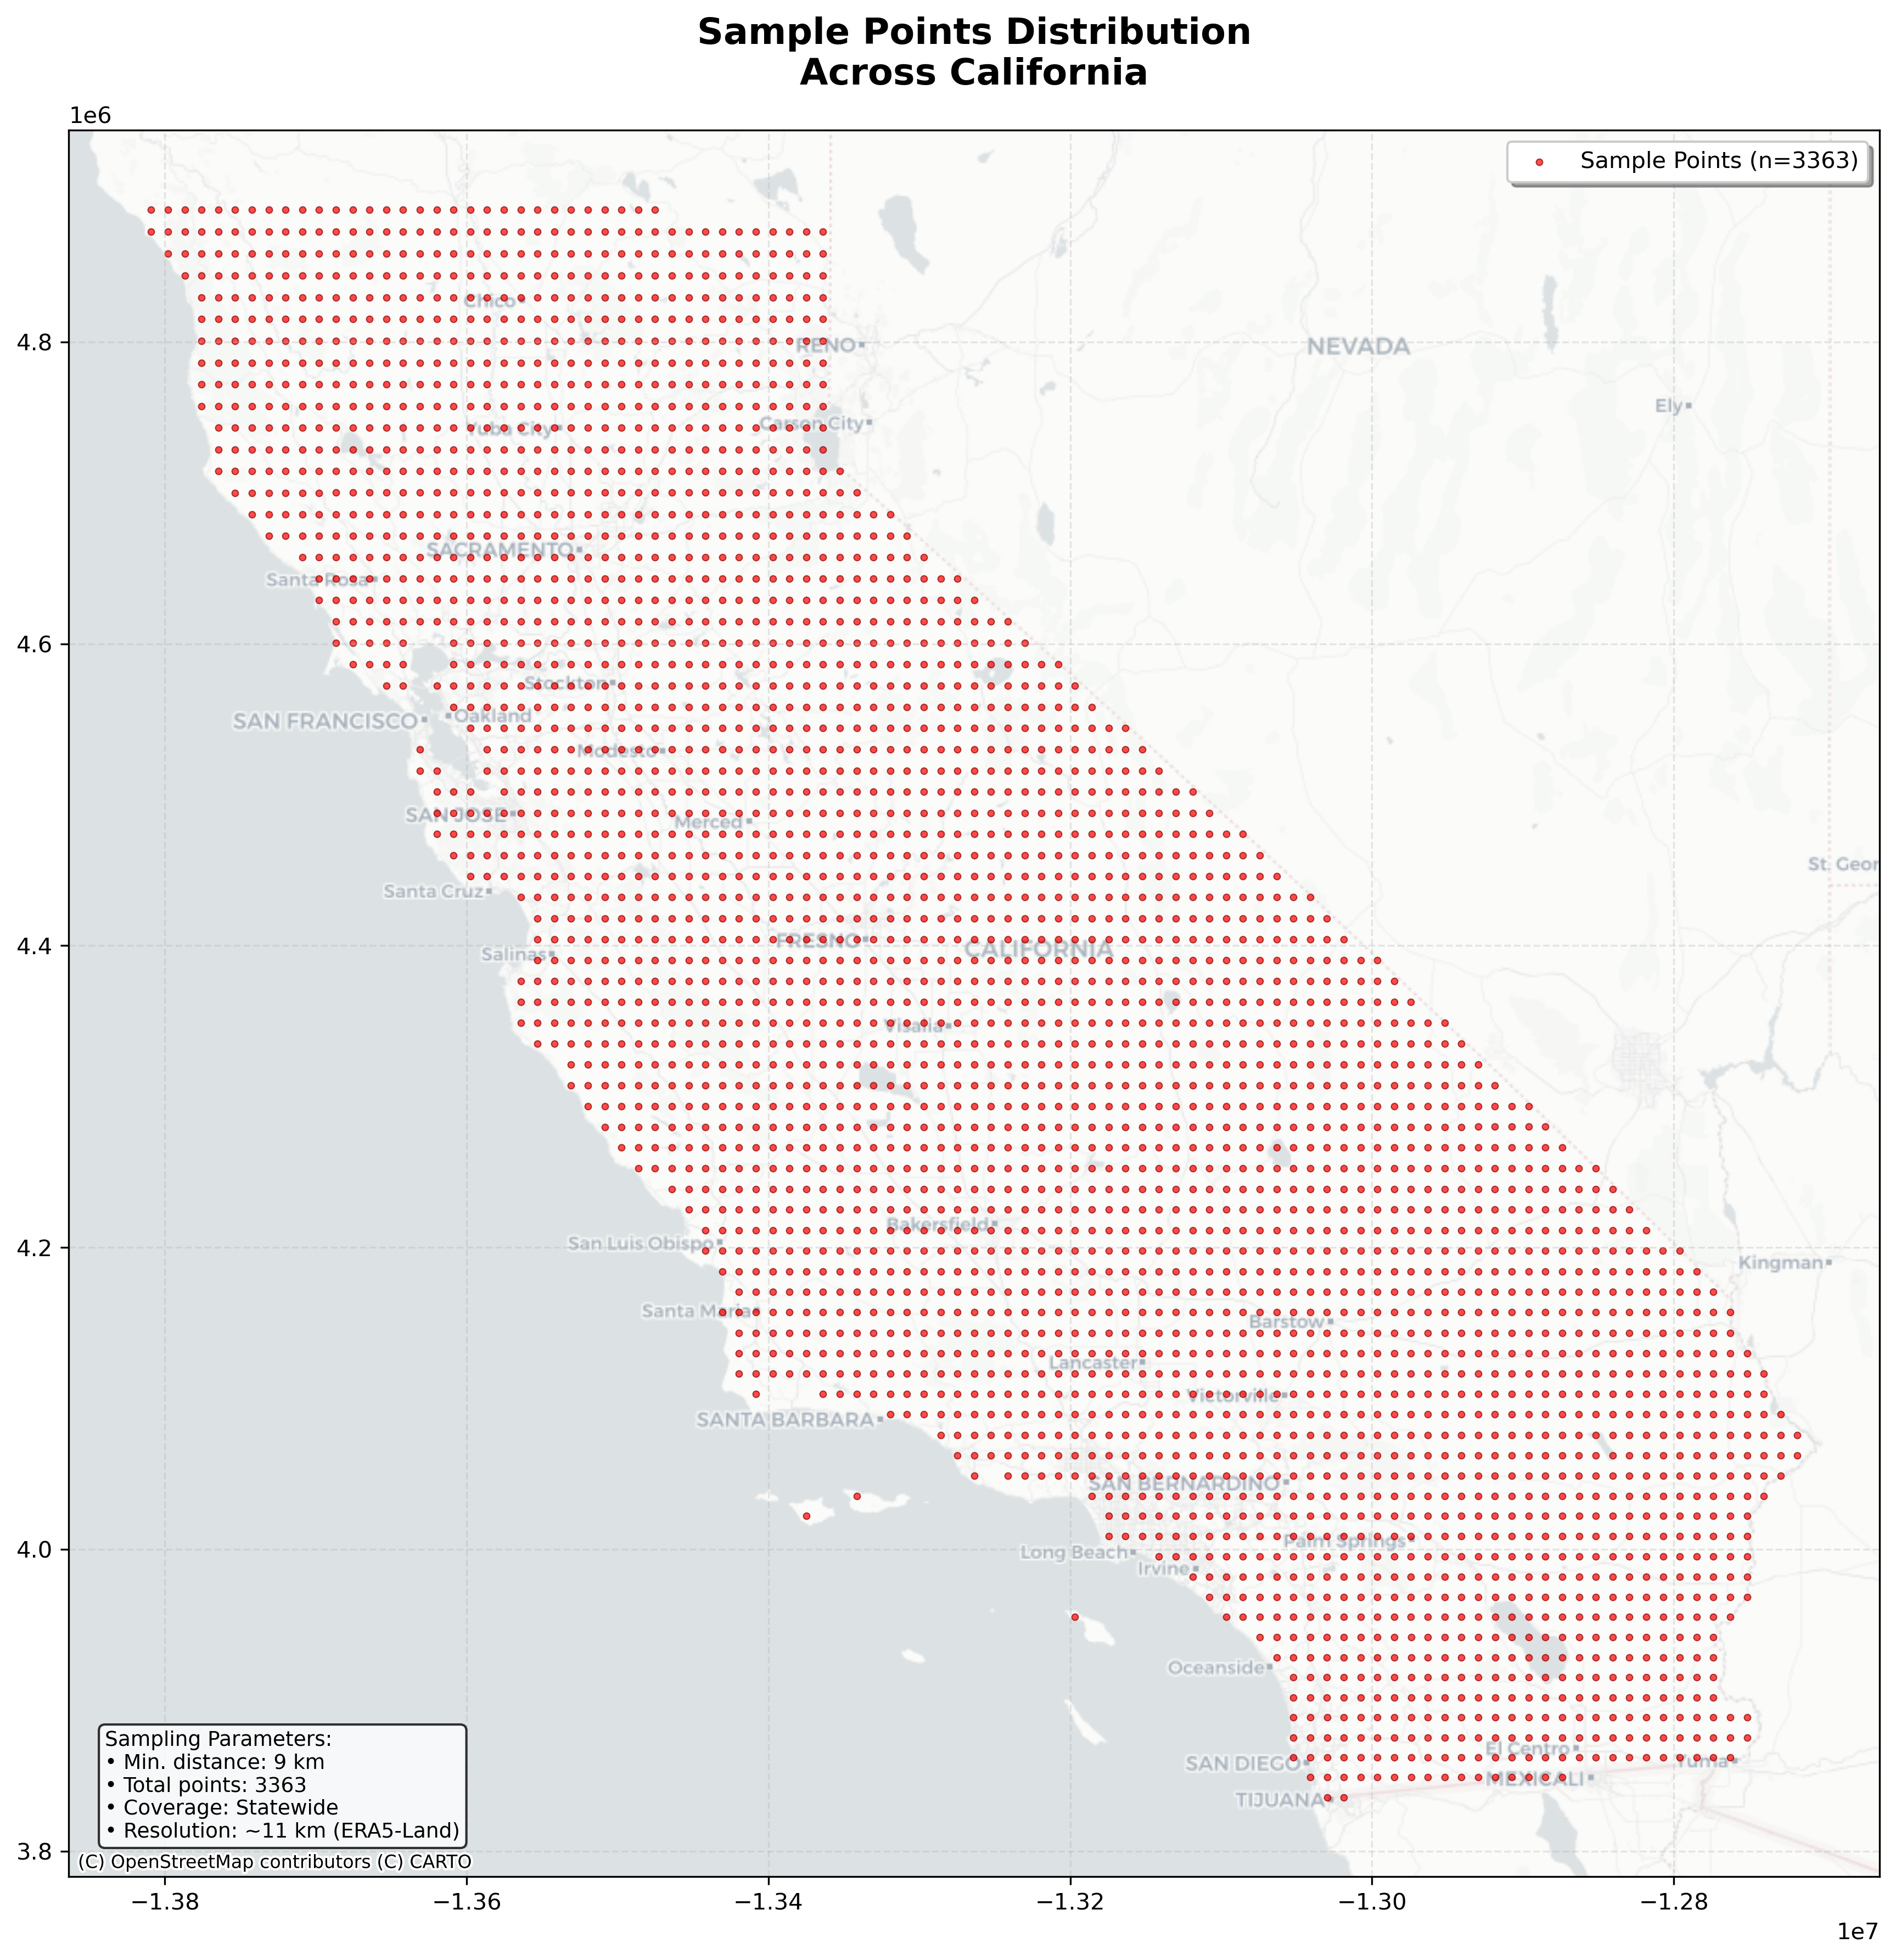


Visualization complete
Files saved:
- california_sample_points.png


In [19]:
def visualize_sample_points(save_figure=True, figsize=(15, 12), dpi=300):
    """
    Create a comprehensive visualization of Earth Engine sample points over California.
    """
    # Reproject to Web Mercator for contextily
    points_mercator = sample_points_gdf.to_crs(epsg=3857)
    
    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
    

    # Plot sample points
    points_mercator.plot(
        ax=ax,
        color='red',
        markersize=8,
        alpha=0.7,
        edgecolors='darkred',
        linewidth=0.5,
        label=f'Sample Points (n={len(sample_points_gdf)})'
    )
    
    # Add contextily basemap
    print("Adding basemap...")
    ctx.add_basemap(
        ax, 
        crs=points_mercator.crs,
        source=ctx.providers.CartoDB.Positron,  # Clean, minimal basemap
        alpha=0.8
    )
    
    # Styling
    ax.set_title(
        'Sample Points Distribution\nAcross California',
        fontsize=16,
        fontweight='bold',
        pad=20
    )
    
    # Remove axis labels (they're in Web Mercator coordinates)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    # Add legend
    ax.legend(
        loc='upper right',
        frameon=True,
        fancybox=True,
        shadow=True,
        fontsize=10
    )
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add text box with sampling information
    info_text = (
        f"Sampling Parameters:\n"
        f"• Min. distance: 9 km\n"
        f"• Total points: {len(sample_points_gdf)}\n"
        f"• Coverage: Statewide\n"
        f"• Resolution: ~11 km (ERA5-Land)"
    )
    
    ax.text(
        0.02, 0.02, info_text,
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment='bottom',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    # Tight layout
    plt.tight_layout()
    
    # Save figure
    if save_figure:
        plt.savefig(
            'gee_california_sample_points.png',
            dpi=dpi,
            bbox_inches='tight',
            facecolor='white'
        )
        print("Figure saved as 'gee_california_sample_points.png'")
    
    plt.show()
    
    return sample_points_gdf

# Main execution
if __name__ == "__main__":
    print("Starting sample points visualization...")
    print("This may take a few minutes to process...")
    
    # Create the main visualization
    sample_points_gdf = visualize_sample_points(
        save_figure=False,
        figsize=(24, 12),
        dpi=300
    )
    
    
print(f"\nVisualization complete")
print(f"Files saved:")
print(f"- california_sample_points.png")